In [1]:
from langgraph.graph import StateGraph, END, START
from langchain_google_genai import ChatGoogleGenerativeAI
from typing import TypedDict, Annotated
from dotenv import load_dotenv
import operator
import os
from langchain_core.prompts import PromptTemplate

/Users/arkajyotikarmakar/LangGraph/LangGraph/myvenv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
load_dotenv()

True

In [3]:
model = ChatGoogleGenerativeAI(
    model = 'gemini-2.5-flash',
    google_api_key = os.getenv('GEMINI_API_KEY')
)

E0000 00:00:1759517735.515631 3523251 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [4]:
class BatsmanStats(TypedDict):

    # runs: int
    # balls: int
    # fours : int
    # sixes : int
    runs: Annotated[int, operator.add]
    balls: Annotated[int, operator.add]
    fours: Annotated[int, operator.add]
    sixes: Annotated[int, operator.add]

    sr: float
    bpb: float
    boundary_percentage: float
    
    summary : str


In [5]:
def calculate_sr(state: BatsmanStats) -> BatsmanStats:

    runs = state['runs']
    balls = state['balls']

    strike_rate = (float)(runs / balls) * 100

    return {'sr': strike_rate}

In [6]:
def calculate_bpb(state: BatsmanStats) -> BatsmanStats:

    runs = state['runs']
    balls = state['balls']
    fours = state['fours']
    sixes = state['sixes']

    total = fours + sixes
    
    bpb = (float)(total / balls)

    return {'bpb': bpb}

In [7]:
def cal_percent(state: BatsmanStats) -> BatsmanStats:

    runs = state['runs']
    balls = state['balls']
    fours = state['fours']
    sixes = state['sixes']

    total_runs = fours * 4 + sixes * 6

    # Calculating boundary percentage

    percent = (float)((total_runs / runs) * 100 )

    return {'boundary_percentage' : percent}

In [8]:
def gen_summary(state: BatsmanStats) -> BatsmanStats:

    sr = state['sr']
    bpb = state['bpb']
    percent = state['boundary_percentage']
    runs = state['runs']
    balls = state['balls']
    fours = state['fours']
    sixes = state['sixes']
    
    prompt = f"Generate a detailed summary which tells about the metrics as if in a Cricket Commentary style : Strike Rate - {sr} , Boundary Percentage - {percent}, Balls Per Boundary - {bpb} , Runs - {runs}, Sixes - {sixes}, Fours - {fours}, balls - { balls} in Hindi"

    result = model.invoke(prompt).content
    
    return {'summary': result}

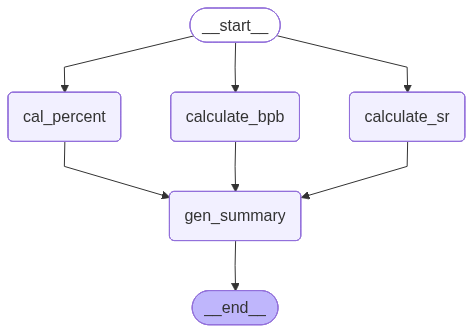

In [9]:
graph = StateGraph(BatsmanStats)

graph.add_node('calculate_sr', calculate_sr)
graph.add_node('calculate_bpb', calculate_bpb)
graph.add_node('cal_percent', cal_percent)
graph.add_node('gen_summary', gen_summary)

graph.add_edge( START, 'calculate_sr')
graph.add_edge( START, 'calculate_bpb')
graph.add_edge( START, 'cal_percent')
graph.add_edge( 'calculate_sr', 'gen_summary')
graph.add_edge( 'calculate_bpb', 'gen_summary')
graph.add_edge( 'cal_percent', 'gen_summary')
graph.add_edge( 'gen_summary', END )

workflow = graph.compile()
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())


In [10]:
initial_state = {
    'runs': 85,
    'balls': 52,
    'fours': 8,
    'sixes': 6
}

final_State = workflow.invoke(initial_state)
print(final_State)

{'runs': 85, 'balls': 52, 'fours': 8, 'sixes': 6, 'sr': 163.46153846153845, 'bpb': 0.2692307692307692, 'boundary_percentage': 80.0, 'summary': 'वाह! क्या तूफानी पारी रही है! आइए, एक क्रिकेट कमेंट्री के अंदाज़ में इस लाजवाब प्रदर्शन का विश्लेषण करते हैं:\n\n**कमेंट्री शुरू:**\n\n"नमस्कार दोस्तों, क्रिकेट के मैदान से सीधी कमेंट्री में आपका स्वागत है! आज हम बात करेंगे एक ऐसी तूफानी पारी की, जिसने आंकड़ों को भी झकझोर कर रख दिया है। यह सिर्फ बल्लेबाजी नहीं थी, यह तो गेंदबाजों के लिए एक अग्निपरीक्षा थी!"\n\n"मैदान पर एक बल्लेबाज ने सिर्फ **52 गेंदों** का सामना करते हुए धुआंधार **85 रन** बनाए हैं। जी हां, सिर्फ 52 गेंदों में 85 रन! यह तो T20 के भी महारथियों को टक्कर देने वाला प्रदर्शन है!"\n\n"इनकी **स्ट्राइक रेट** देखिए - **163.46**! यह दिखाता है कि बल्लेबाज ने हर गेंद पर रन बनाने की ठान रखी थी। गेंदबाजों को जरा भी संभलने का मौका नहीं दिया, हर ओवर में रनों की बरसात होती रही। दबाव पूरी तरह से गेंदबाजों पर था!"\n\n"और अब बात करते हैं बाउंड्री की। कुल रनों का **80.0%** हिस्सा बाउंड्री से आया है!